In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import h5py
import os
import yaml
from scipy import signal
from scipy.stats import poisson, iqr
from scipy.optimize import curve_fit
from IPython.display import Image
from sklearn.metrics import mean_squared_error

Point these files and directories to the correct locations on NERSC or on an external drive, if the data was downloaded. 

In [141]:
DCA_800_FRAME_DATA_CSV_FILE = '/global/cfs/cdirs/m2043/balewski/neuronBBP-misc-8kHz/pred-info-169cell-800frames/pred-info-800frames-8kHz-T16_169cell.csv'
DCA_300_TO_700FRAME_DATA_CSV_DIR = '/global/cfs/cdirs/m2043/balewski/neuronBBP-misc-8kHz/pred-info-169cell-per1frame/'
CELL_SPECIFIC_DATA_DIR = '/global/cfs/cdirs/m2043/balewski/neuronBBP-data_67pr/'
DCA_800_FRAME_DATASET = pd.read_csv(DCA_800_FRAME_DATA_CSV_FILE)
print(DCA_800_FRAME_DATASET)

       # cellName  samples  inpDim   dca.d   dca.T     PI          jobID  \
0      #   bbp001      800      67       1      16   3.62   37401473/0/0   
1      #   bbp001      800      67       1      16   3.70  37401473/0/10   
2      #   bbp001      800      67       1      16   3.87  37401473/0/11   
3      #   bbp001      800      67       1      16   3.94   37401473/0/1   
4      #   bbp001      800      67       1      16   3.80   37401473/0/2   
...   ..      ...      ...     ...     ...     ...    ...            ...   
19638  #   bbp179      800      62      62      16  37.24  37420132/18/5   
19639  #   bbp179      800      62      62      16  41.91  37420132/18/6   
19640  #   bbp179      800      62      62      16  45.17  37420132/18/7   
19641  #   bbp179      800      62      62      16  45.52  37420132/18/8   
19642  #   bbp179      800      62      62      16  45.56  37420132/18/9   

       cov_time  fit_time   tot_time  
0           2.1       0.6        2.8  
1        

To start we'll sort the provided cells in the CSV file into their types L1, L23, L4, L5 and L6. 

In [158]:
SORTED_CELL_TYPES = {'L1' : [], 'L23' : [], 'L4' : [], 'L5' : [], 'L6' : []}

for cell in DCA_800_FRAME_DATASET['cellName'].unique():
    with open(CELL_SPECIFIC_DATA_DIR + cell + '/meta.cellSpike.yaml', 'r') as file:
        cell_info = yaml.safe_load(file)
    cell_type = cell_info['rawInfo']['bbpName'][:2]
    if cell_type == 'L2':
        cell_type = 'L23'
    SORTED_CELL_TYPES[cell_type].append(cell)

# This will be used later when we apply aggregate curve fitting
print(SORTED_CELL_TYPES)

{'L1': ['bbp001', 'bbp002', 'bbp003', 'bbp004', 'bbp005', 'bbp006', 'bbp007', 'bbp008', 'bbp009', 'bbp010', 'bbp011', 'bbp012', 'bbp013', 'bbp014'], 'L23': ['bbp017', 'bbp018', 'bbp019', 'bbp020', 'bbp023', 'bbp024', 'bbp025', 'bbp026', 'bbp027', 'bbp028', 'bbp031', 'bbp032', 'bbp034', 'bbp035', 'bbp036', 'bbp037', 'bbp038', 'bbp040', 'bbp041', 'bbp042', 'bbp043', 'bbp045', 'bbp046', 'bbp047', 'bbp048', 'bbp049', 'bbp050', 'bbp051', 'bbp052', 'bbp053', 'bbp054', 'bbp055', 'bbp056', 'bbp057'], 'L4': ['bbp060', 'bbp061', 'bbp062', 'bbp063', 'bbp066', 'bbp067', 'bbp068', 'bbp069', 'bbp070', 'bbp071', 'bbp072', 'bbp075', 'bbp076', 'bbp077', 'bbp078', 'bbp079', 'bbp080', 'bbp081', 'bbp082', 'bbp083', 'bbp084', 'bbp086', 'bbp087', 'bbp088', 'bbp089', 'bbp090', 'bbp091', 'bbp092', 'bbp093', 'bbp094', 'bbp095', 'bbp096', 'bbp097', 'bbp098', 'bbp099', 'bbp100', 'bbp101', 'bbp102'], 'L5': ['bbp106', 'bbp107', 'bbp108', 'bbp109', 'bbp111', 'bbp112', 'bbp113', 'bbp114', 'bbp115', 'bbp118', 'bbp119

# 1. DCA Dimension vs Predictive Information Graphs (800 Frame Average)
For each simulated cell, and a given number of dynamical components, the predictive information (PI) was averaged over 800 frames for a total of 12 samples per cell and number of DCA dimensions (DCA d). The window size used to compute the dynamic components was 2ms (i.e. 16 bins). The following code allows comparison between the raw predictive information computed across different cells. Violin plots were used to account for the variance in the calculated predictive information for a given number of DCA components. 

The amount of predictive information gained by using a given number of dynamical components offers a crude method of comparing the complexities between cells. 

In [4]:
def graph_DCA_vs_PI(cell_names, img_width=6, img_height=4.5, cell_type='', labels_to_use=None, show_violins=True):
    '''
    cell_names should be a list of cells to graph labeled bbpXXX format. 
    '''
    plt.figure(figsize=(img_width, img_height))
    DCA_800FRAME_DATA = pd.read_csv(DCA_800_FRAME_DATA_CSV_FILE)
    for i in range(len(cell_names)):
        dca_vs_pi_means= DCA_800FRAME_DATA[DCA_800FRAME_DATA['cellName'] == cell_names[i]].groupby(' dca.d')[' PI'].mean().to_frame().reset_index()
        pi_corresponding_to_dim = DCA_800FRAME_DATA[DCA_800FRAME_DATA['cellName'] == cell_names[i]].groupby(' dca.d')[' PI'].apply(lambda x: x.values).values
        if labels_to_use != None:
            plt.plot(dca_vs_pi_means[' dca.d'], dca_vs_pi_means[' PI'], linestyle='dotted', marker='${}$'.format(i),label=labels_to_use[i])
        else: 
            plt.plot(dca_vs_pi_means[' dca.d'], dca_vs_pi_means[' PI'], linestyle='dotted', marker='${}$'.format(i),label=cell_names[i])
        if show_violins:
            # Make the violin plot appear at each point
            violin = plt.violinplot(pi_corresponding_to_dim, positions=dca_vs_pi_means[' dca.d'].unique(), widths=2, showextrema=False)
            # For making the violin the same color as the mean
            for param in violin['bodies']:
                param.set_facecolor(plt.gca().lines[-1].get_color())

    plt.xlabel('DCA d (dimension)')
    plt.ylabel('DCA Predictive Information (PI)')
    plt.title(cell_type + ': T = 2ms ({} bins), num_frames:{}, dataSets:{}'.format(16, 800, 12))
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return plt

## 1.1 Absolute Predictive Information

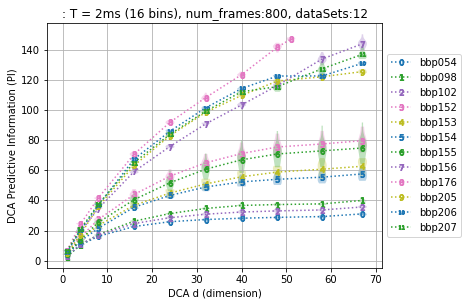

In [5]:
graph_DCA_vs_PI(['bbp054', 'bbp098', 'bbp102', 'bbp152', 'bbp153', 'bbp154', 'bbp155', 'bbp156', 'bbp176', 'bbp205', 'bbp206', 'bbp207']).show()

### 1.1.1 Plots of absolute PI over 800 frames for random inhibitory cells of certain types

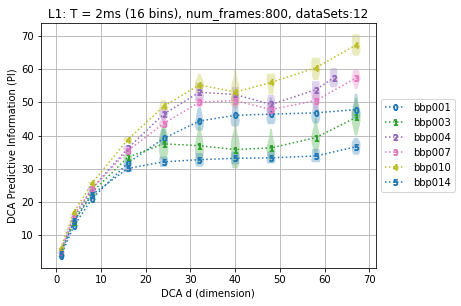

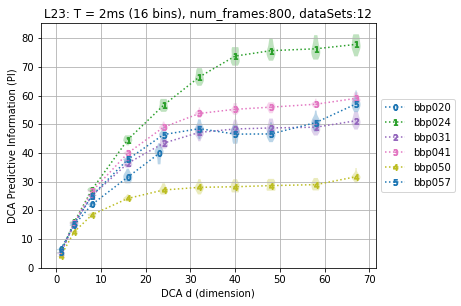

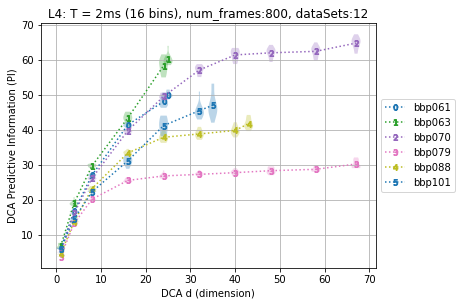

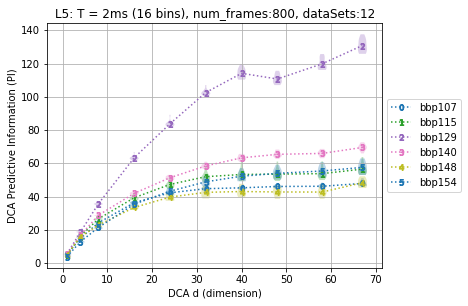

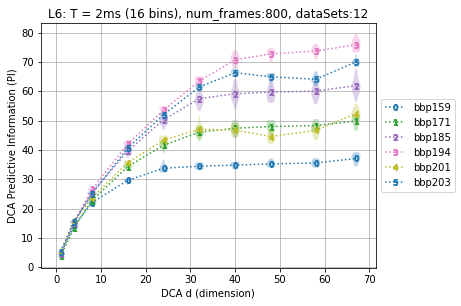

In [148]:
# L1
graph_DCA_vs_PI(['bbp001', 'bbp003', 'bbp004', 'bbp007', 'bbp010', 'bbp014'], cell_type = 'L1').show()
# L23
graph_DCA_vs_PI(['bbp020', 'bbp024', 'bbp031', 'bbp041', 'bbp050', 'bbp057'], cell_type = 'L23').show()
# L4
graph_DCA_vs_PI(['bbp061', 'bbp063', 'bbp070', 'bbp079', 'bbp088', 'bbp101'], cell_type = 'L4').show()
# L5
graph_DCA_vs_PI(['bbp107', 'bbp115', 'bbp129', 'bbp140', 'bbp148', 'bbp154'], cell_type = 'L5').show()
# L6
graph_DCA_vs_PI(['bbp159', 'bbp171', 'bbp185', 'bbp194', 'bbp201', 'bbp203'], cell_type = 'L6').show()

We can visualize the differences in DCA dimension vs predictive information across different cell types. Specficially, plots comparing inhibitory vs excitatory and simple vs complex cells are shown below. For this exact ploy, cells bbp019, bbp027, bbp102, and bbp153 were compared against each other. The max average normalized graph of these same cells appears in the next section.

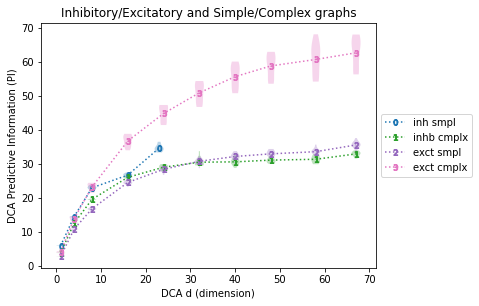

In [7]:
DCA_vs_PI_signal_type = graph_DCA_vs_PI(['bbp019','bbp027','bbp102','bbp153'], labels_to_use=['inh smpl', 'inhb cmplx', 'exct smpl', 'exct cmplx'])
DCA_vs_PI_signal_type.title('Inhibitory/Excitatory and Simple/Complex graphs')
DCA_vs_PI_signal_type.grid(False)
DCA_vs_PI_signal_type.show()

### 1.1.2 Curve-fitted Data

For a sample of cell-types we compute a log fit for the data of the form $A\log (d) + B$, where $d$ is DCA dimension and $A,B\in\mathbb{R}$ are constants.

<Figure size 432x324 with 0 Axes>

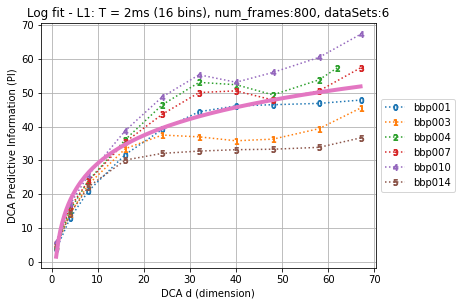

<Figure size 432x324 with 0 Axes>

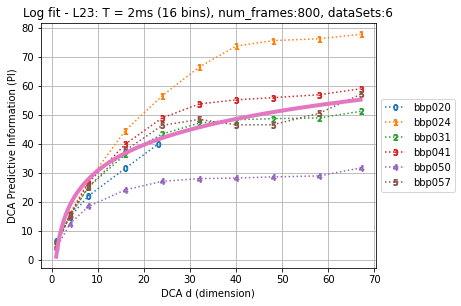

<Figure size 432x324 with 0 Axes>

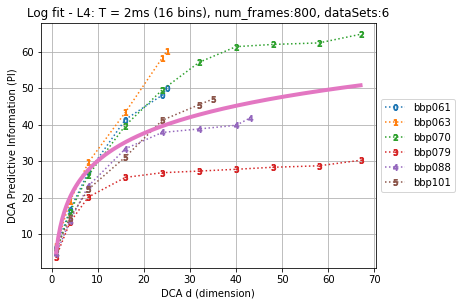

<Figure size 432x324 with 0 Axes>

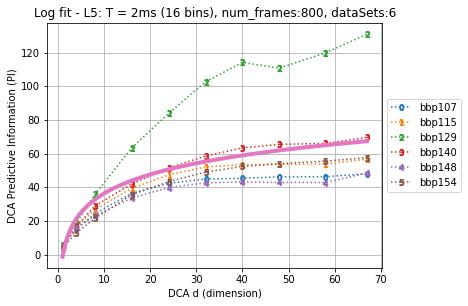

<Figure size 432x324 with 0 Axes>

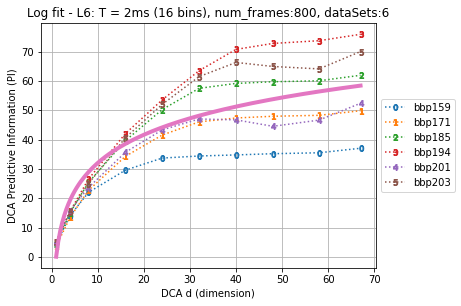

(13.84769848355668, 0.1864129857892809)

In [8]:
def log_fit_DCA_vs_PI(cell_names, img_width=6, img_height=4.5, cell_type='', labels_to_use=None):
    plt.figure(figsize=(img_width, img_height))
    DCA_800FRAME_DATA = pd.read_csv(DCA_800_FRAME_DATA_CSV_FILE)
    dca_vs_pi_plot = graph_DCA_vs_PI(cell_names, cell_type=cell_type, show_violins=False)
    # computes average PI for DCA d across everthing in cell_names for the log_fit. 
    dca_vs_pi_avg_across_cell_names= DCA_800FRAME_DATA[DCA_800FRAME_DATA['cellName'].isin(cell_names)].groupby(' dca.d')[' PI'].mean().to_frame().reset_index()
    
    X_dca = dca_vs_pi_avg_across_cell_names[' dca.d']
    Y_pi = dca_vs_pi_avg_across_cell_names[' PI']
    params, _ = curve_fit(lambda d, A, B: A * np.log(d) + B, X_dca, Y_pi)
    A = params[0]
    B = params[1] 
    X_fit = np.linspace(np.min(X_dca), np.max(X_dca), 150)
    Y_fit = A * np.log(X_fit) + B
    
    dca_vs_pi_plot.plot(X_fit, Y_fit, linewidth=4)
    dca_vs_pi_plot.title('Log fit - ' + cell_type + ': T = 2ms ({} bins), num_frames:{}, dataSets:{}'.format(16, 800, len(cell_names)))
    dca_vs_pi_plot.show()
    return A, B

log_fit_DCA_vs_PI(['bbp001', 'bbp003', 'bbp004', 'bbp007', 'bbp010', 'bbp014'], cell_type = 'L1')
log_fit_DCA_vs_PI(['bbp020', 'bbp024', 'bbp031', 'bbp041', 'bbp050', 'bbp057'], cell_type = 'L23')
log_fit_DCA_vs_PI(['bbp061', 'bbp063', 'bbp070', 'bbp079', 'bbp088', 'bbp101'], cell_type = 'L4')
log_fit_DCA_vs_PI(['bbp107', 'bbp115', 'bbp129', 'bbp140', 'bbp148', 'bbp154'], cell_type = 'L5')
log_fit_DCA_vs_PI(['bbp159', 'bbp171', 'bbp185', 'bbp194', 'bbp201', 'bbp203'], cell_type = 'L6')

<Figure size 432x324 with 0 Axes>

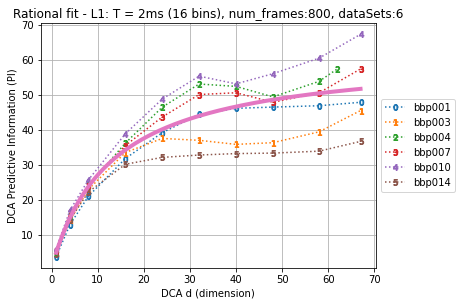

<Figure size 432x324 with 0 Axes>

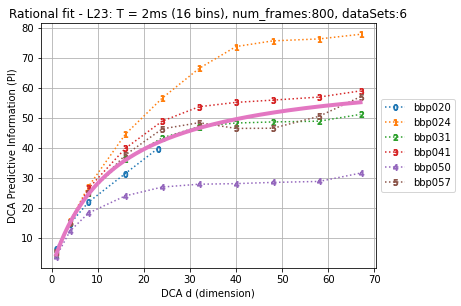

<Figure size 432x324 with 0 Axes>

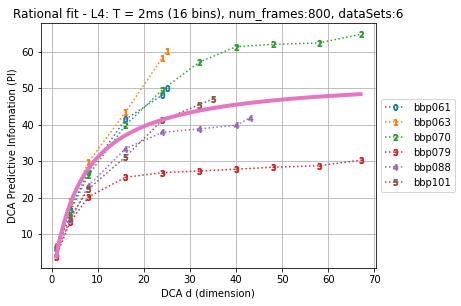

<Figure size 432x324 with 0 Axes>

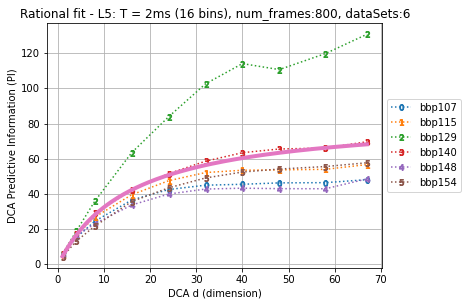

<Figure size 432x324 with 0 Axes>

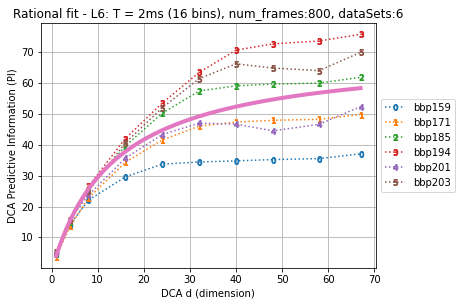

(1.583735166999515,
 -0.29408291437093215,
 0.02253551147892908,
 0.3016816699862483)

In [9]:
# Fits curve to a rational function of the form (Ax + B)/(Cx + D)

def rational_fit_DCA_vs_PI(cell_names, img_width=6, img_height=4.5, cell_type='', labels_to_use=None):
    plt.figure(figsize=(img_width, img_height))
    DCA_800FRAME_DATA = pd.read_csv(DCA_800_FRAME_DATA_CSV_FILE)
    dca_vs_pi_plot = graph_DCA_vs_PI(cell_names, cell_type=cell_type, show_violins=False)
    # computes average PI for DCA d across everthing in cell_names for the log_fit. 
    dca_vs_pi_avg_across_cell_names= DCA_800FRAME_DATA[DCA_800FRAME_DATA['cellName'].isin(cell_names)].groupby(' dca.d')[' PI'].mean().to_frame().reset_index()
    
    X_dca = dca_vs_pi_avg_across_cell_names[' dca.d']
    Y_pi = dca_vs_pi_avg_across_cell_names[' PI']
    params, _ = curve_fit(lambda d, A, B, C, D:  (A * d + B) / (C * d + D), X_dca, Y_pi)
    A = params[0]
    B = params[1] 
    C = params[2]
    D = params[3]
    X_fit = np.linspace(np.min(X_dca), np.max(X_dca), 150)
    Y_fit = (A * X_fit + B) / (C * X_fit + D) 
    
    dca_vs_pi_plot.plot(X_fit, Y_fit, linewidth=4)
    dca_vs_pi_plot.title('Rational fit - ' + cell_type + ': T = 2ms ({} bins), num_frames:{}, dataSets:{}'.format(16, 800, len(cell_names)))
    dca_vs_pi_plot.show()
    return A, B, C, D 

rational_fit_DCA_vs_PI(['bbp001', 'bbp003', 'bbp004', 'bbp007', 'bbp010', 'bbp014'], cell_type = 'L1')
rational_fit_DCA_vs_PI(['bbp020', 'bbp024', 'bbp031', 'bbp041', 'bbp050', 'bbp057'], cell_type = 'L23')
rational_fit_DCA_vs_PI(['bbp061', 'bbp063', 'bbp070', 'bbp079', 'bbp088', 'bbp101'], cell_type = 'L4')
rational_fit_DCA_vs_PI(['bbp107', 'bbp115', 'bbp129', 'bbp140', 'bbp148', 'bbp154'], cell_type = 'L5')
rational_fit_DCA_vs_PI(['bbp159', 'bbp171', 'bbp185', 'bbp194', 'bbp201', 'bbp203'], cell_type = 'L6')

## 1.2 Max Average Normalization

To accurately compare the complexities of neurons against each other, the amount of mutual information must be normalized. The relative information conent of the neurons were plotted by dividing the predicitve information by the mean predictive information for the largest available DCA dimension available for the given cell in the dataset. Mathematically, if $d_{max}$ denotes the largest available DCA dimension, and $I^{avg}_{d_{max}}$ denotes the mean predictive information for that specific dimension, then all provided values of predictive information for the cell were divided by $I^{avg}_{d_{max}}$.

In [10]:
def graph_DCA_vs_PI_maxavg_normalization(cell_names, sigma_scale=2, img_width=6, img_height=4.5, cell_type='', labels_to_use=None, show_violins=True):
    '''
    cell_names should be a list of cells to graph labeled bbpXXX format. 
    sigma_scale makes the uncertainty equal to sigma_scale * calculated SD
    '''
    plt.figure(figsize=(img_width, img_height))
    DCA_800FRAME_DATA = pd.read_csv(DCA_800_FRAME_DATA_CSV_FILE)
    for i in range(len(cell_names)):
        dca_vs_pi_means= DCA_800FRAME_DATA[DCA_800FRAME_DATA['cellName'] == cell_names[i]].groupby(' dca.d')[' PI'].mean().to_frame().reset_index()
        dca_vs_pi_means['normalized PI'] = dca_vs_pi_means[' PI'] / dca_vs_pi_means[' PI'].max()
        pi_corresponding_to_dim = DCA_800FRAME_DATA[DCA_800FRAME_DATA['cellName'] == cell_names[i]].groupby(' dca.d')[' PI'].apply(lambda x: x.values).values
        if labels_to_use == None:
            plt.plot(dca_vs_pi_means[' dca.d'], dca_vs_pi_means['normalized PI'], linestyle='dotted', marker='${}$'.format(i),label=cell_names[i])
        else:
            plt.plot(dca_vs_pi_means[' dca.d'], dca_vs_pi_means['normalized PI'], linestyle='dotted', marker='${}$'.format(i),label=labels_to_use[i])
        if show_violins:
            normalized_pi_corresponding_to_dim = pi_corresponding_to_dim / dca_vs_pi_means[' PI'].max()
            violin = plt.violinplot(normalized_pi_corresponding_to_dim, positions=dca_vs_pi_means[' dca.d'].unique(), widths=2, showextrema=False)
            # For making the violin the same color as the mean
            for param in violin['bodies']:
                param.set_facecolor(plt.gca().lines[-1].get_color())
            
    plt.xlabel('DCA d (dimension)')
    plt.ylabel('DCA Relative Predictive Information (PI)')
    plt.title(cell_type + ': T = 2ms ({} bins), num_frames:{}, dataSets:{}'.format(16, 800, len(cell_names)))
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return plt

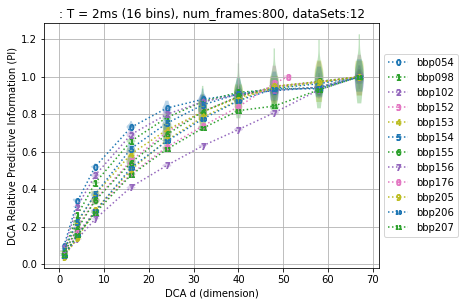

In [11]:
graph_DCA_vs_PI_maxavg_normalization(['bbp054', 'bbp098', 'bbp102', 'bbp152', 'bbp153', \
                                      'bbp154', 'bbp155', 'bbp156', 'bbp176', 'bbp205', 'bbp206', 'bbp207']).show()

### Plots of relative PI over 800 frames for random inhibitory cells of certain types

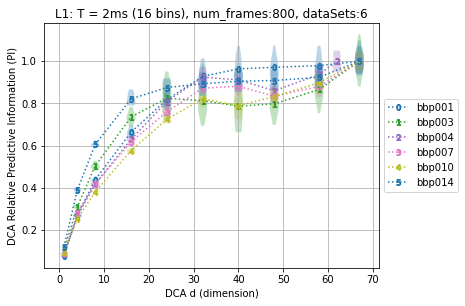

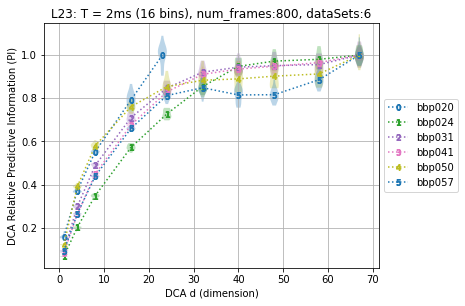

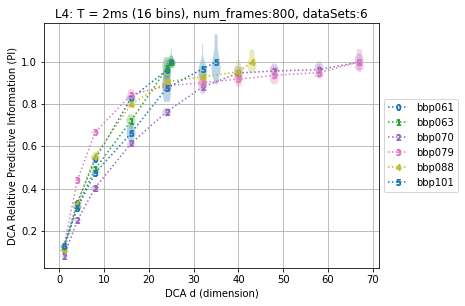

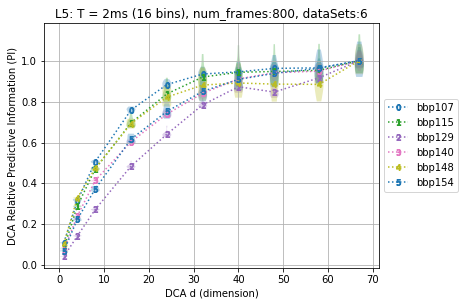

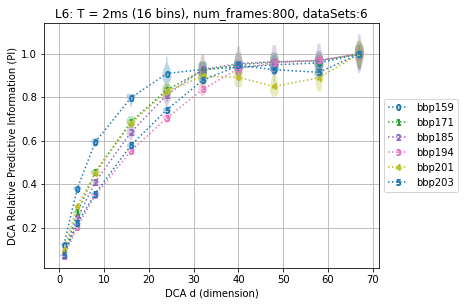

In [12]:
# L1
graph_DCA_vs_PI_maxavg_normalization(['bbp001', 'bbp003', 'bbp004', 'bbp007', 'bbp010', 'bbp014'], cell_type = 'L1').show()
# L23
graph_DCA_vs_PI_maxavg_normalization(['bbp020', 'bbp024', 'bbp031', 'bbp041', 'bbp050', 'bbp057'], cell_type = 'L23').show()
# L4
graph_DCA_vs_PI_maxavg_normalization(['bbp061', 'bbp063', 'bbp070', 'bbp079', 'bbp088', 'bbp101'], cell_type = 'L4').show()
# L5
graph_DCA_vs_PI_maxavg_normalization(['bbp107', 'bbp115', 'bbp129', 'bbp140', 'bbp148', 'bbp154'], cell_type = 'L5').show()
# L6
graph_DCA_vs_PI_maxavg_normalization(['bbp159', 'bbp171', 'bbp185', 'bbp194', 'bbp201', 'bbp203'], cell_type = 'L6').show()

Max Average normalization of inhibitory vs excitatory and simple vs complex cells.

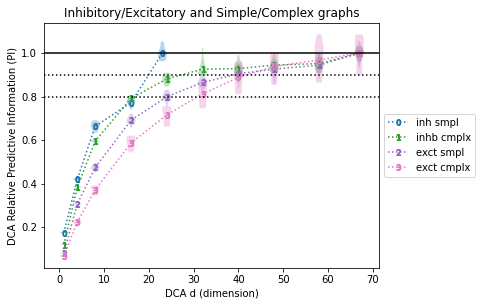

In [13]:
DCA_vs_PI_signal_type_normalized = graph_DCA_vs_PI_maxavg_normalization(['bbp019', 'bbp027', 'bbp102','bbp153'], \
                                                                        labels_to_use=['inh smpl', 'inhb cmplx', 'exct smpl', 'exct cmplx'])
DCA_vs_PI_signal_type_normalized.axhline(y=1, color='black')
DCA_vs_PI_signal_type_normalized.axhline(y=0.9, color='black', linestyle='dotted')
DCA_vs_PI_signal_type_normalized.axhline(y=0.8, color='black', linestyle='dotted')
DCA_vs_PI_signal_type_normalized.title('Inhibitory/Excitatory and Simple/Complex graphs')
DCA_vs_PI_signal_type_normalized.grid(False)
DCA_vs_PI_signal_type_normalized.show()

Each point on the graph can be thought of as measuring a fraction of the maximum amount of information that can be gained by obtaining more dimensions. The disadvantage of this method is that it is not clear why dividing by the largest mean predicitive information for each cell allows for comparison between cells. 

### 1.2.1 Curve-fitted Data

In [226]:
def curve_fit_DCA_vs_PI(cell_names, img_width=6, img_height=4.5, cell_type='', fit='log', labels_to_use=None,
                                             normalizer='maxavg', include_thresh=True):
    '''
    fit is a paramter that can be log for a * log x + b fit, 
    rational for a (a * x + b)/(c * x + d) fit
    power for a x^q fit
    exp for a fit to 1-e^(a * x)
    tanh for fit to tanh(a * x)
    '''
    plt.figure(figsize=(img_width, img_height))
    DCA_800FRAME_DATA = pd.read_csv(DCA_800_FRAME_DATA_CSV_FILE)
    
    # computes average PI for DCA d across everthing in cell_names for the log_fit. 
    grouped_data = DCA_800FRAME_DATA[DCA_800FRAME_DATA['cellName'].isin(cell_names)].groupby(['cellName', ' dca.d'])[' PI'].mean()
    dca_vs_pi_avg_across_cell_names = grouped_data.to_frame().reset_index()
    
    X_dca = dca_vs_pi_avg_across_cell_names[' dca.d']
    
    if normalizer == 'maxavg':
        dca_vs_pi_avg_across_cell_names['normalized PI'] = dca_vs_pi_avg_across_cell_names.groupby('cellName')[' PI'].transform(lambda x: x / x.max())
        Y_pi = dca_vs_pi_avg_across_cell_names['normalized PI']
        dca_vs_pi_plot = graph_DCA_vs_PI_maxavg_normalization(cell_names, cell_type=cell_type, show_violins=False)
    ## normalizer = 'unnorm'
    else:
        Y_pi = dca_vs_pi_avg_across_cell_names[' PI']
        dca_vs_pi_plot = graph_DCA_vs_PI(cell_names, cell_type=cell_type, show_violins=False)

    if fit == 'log':
        params, _ = curve_fit(lambda d, A, B: A * np.log(d) + B, X_dca, Y_pi)
        A = params[0]
        B = params[1] 
        X_fit = np.linspace(np.min(X_dca), np.max(X_dca), 150)
        Y_fit = A * np.log(X_fit) + B
        Y_pred = A * np.log(X_dca) + B
        
        dca_vs_pi_plot.plot(X_fit, Y_fit, linewidth=2, color='black')
        dca_vs_pi_plot.title('Log fit - ' + cell_type + ': T = 2ms ({} bins), num_frames:{}, dataSets:{}'.format(16, 800, len(cell_names)))
        dca_vs_pi_plot.show()    
        return {'MSE' : mean_squared_error(Y_pred, Y_pi), 'params' : [A, B]}
    elif fit == 'rat':
        params, _ = curve_fit(lambda d, A, B, C, D: (A * d + B) / (C * d + D), X_dca, Y_pi, bounds=([0, np.inf]))
        A = params[0]
        B = params[1] 
        C = params[2]
        D = params[3]
        X_fit = np.linspace(np.min(X_dca), np.max(X_dca), 150)
        Y_fit = (A * X_fit + B) / (C * X_fit + D)
        Y_pred = (A * X_dca + B) / (C * X_dca + D)
        
        squared_loss = mean_squared_error(Y_pred, Y_pi)
        
        if include_thresh:
            dca_vs_pi_plot.axhline(y=A / C, color='black')
            dca_vs_pi_plot.axhline(y=A / C + np.sqrt(squared_loss), color='black', linestyle='dashed')
            dca_vs_pi_plot.axhline(y=A / C - np.sqrt(squared_loss), color='black', linestyle='dashed')
        
        dca_vs_pi_plot.plot(X_fit, Y_fit, linewidth=2, color='black')
        dca_vs_pi_plot.title('Rational fit - ' + cell_type + ': T = 2ms ({} bins), num_frames:{}, dataSets:{}'.format(16, 800, len(cell_names)))
        dca_vs_pi_plot.show()
        return {'MSE' : squared_loss, 'params' : [A, B, C, D], 'threshold' : A / C}
    elif fit == 'pow':
        params, _ = curve_fit(lambda d, A, B: A * np.power(d, B), X_dca, Y_pi, bounds=([0, np.inf]))
        A = params[0]
        B = params[1] 
        X_fit = np.linspace(np.min(X_dca), np.max(X_dca), 150)
        Y_fit = A * np.power(X_fit, B)
        Y_pred = A * np.power(X_dca, B)
        
        dca_vs_pi_plot.plot(X_fit, Y_fit, linewidth=2, color='black')
        dca_vs_pi_plot.title('Power fit - ' + cell_type + ': T = 2ms ({} bins), num_frames:{}, dataSets:{}'.format(16, 800, len(cell_names)))
        dca_vs_pi_plot.show()
        return {'MSE' : mean_squared_error(Y_pred, Y_pi), 'params' : [A, B]}
    elif fit == 'exp':
        params, _ = curve_fit(lambda d, A, B: A * (1 - np.exp(- d * B)), X_dca, Y_pi, bounds=([0, np.inf]))
        A = params[0]
        B = params[1]
        X_fit = np.linspace(np.min(X_dca), np.max(X_dca), 150)
        Y_fit = A * (1 - np.exp(- B * X_fit))
        Y_pred = A * (1 - np.exp(- B * X_dca))
        
        squared_loss = mean_squared_error(Y_pred, Y_pi)
        
        if include_thresh:
            dca_vs_pi_plot.axhline(y=A, color='black')
            dca_vs_pi_plot.axhline(y=A + np.sqrt(squared_loss), color='black', linestyle='dashed')
            dca_vs_pi_plot.axhline(y=A - np.sqrt(squared_loss), color='black', linestyle='dashed')

        dca_vs_pi_plot.plot(X_fit, Y_fit, linewidth=2, color='black')
        dca_vs_pi_plot.title('Exponential fit - ' + cell_type + ': T = 2ms ({} bins), num_frames:{}, dataSets:{}'.format(16, 800, len(cell_names)))
        dca_vs_pi_plot.show()
        return {'MSE' : squared_loss, 'params' : [A, B], 'threshold' : A}
    elif fit == 'tanh':
        params, _ = curve_fit(lambda d, A, B: A * np.tanh(B * d), X_dca, Y_pi)
        A = params[0]
        B = params[1]
        X_fit = np.linspace(np.min(X_dca), np.max(X_dca), 150)
        Y_fit = A * np.tanh(B * X_fit)
        Y_pred = A * np.tanh(B * X_dca)
        
        squared_loss = mean_squared_error(Y_pred, Y_pi)

        if include_thresh:
            dca_vs_pi_plot.axhline(y=A, color='black')
            dca_vs_pi_plot.axhline(y=A + np.sqrt(squared_loss), color='black', linestyle='dashed')
            dca_vs_pi_plot.axhline(y=A - np.sqrt(squared_loss), color='black', linestyle='dashed')
        
        dca_vs_pi_plot.plot(X_fit, Y_fit, linewidth=2, color='black')
        dca_vs_pi_plot.title('Tanh fit - ' + cell_type + ': T = 2ms ({} bins), num_frames:{}, dataSets:{}'.format(16, 800, len(cell_names)))
        dca_vs_pi_plot.show()
        return {'MSE' : squared_loss, 'params' : [A, B], 'threshold' : A}
    else:
        return 'Invalid flag for fit'

Our goal with the following code is to construct a cutoff threshold for mutual information to measure the complexity of neurons. The cutoff threshold is set per class, so in the code below, every neuron of type L1 was used to construct the threshold. 

To obtain the threshold, we simple average all data points 

<Figure size 432x324 with 0 Axes>

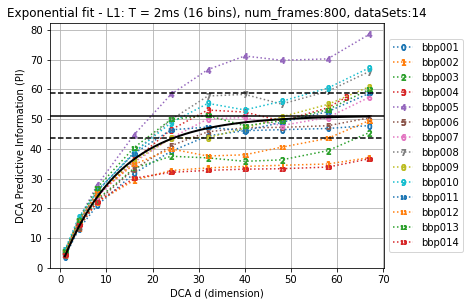

{'MSE': 59.09332762031511, 'params': [51.15928187131651, 0.07807632571326849], 'threshold': 51.15928187131651}


<Figure size 432x324 with 0 Axes>

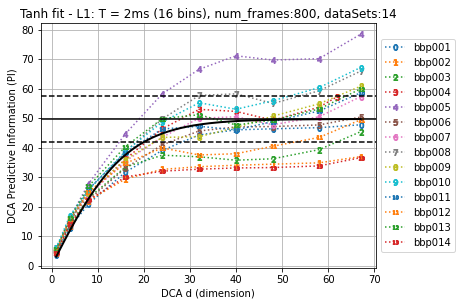

{'MSE': 61.80167644912664, 'params': [49.782042206216644, 0.06152283654729524], 'threshold': 49.782042206216644}


<Figure size 432x324 with 0 Axes>

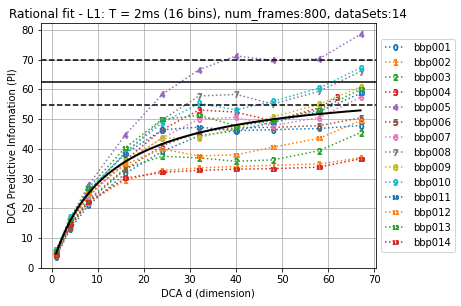

{'MSE': 58.037329431141565, 'params': [33.73513782472288, 2.073772963058209e-20, 0.5410688111815541, 6.464019996604667], 'threshold': 62.349071185703856}


In [227]:
%matplotlib inline

L1 = SORTED_CELL_TYPES['L1'] # ['bbp001', 'bbp003', 'bbp004', 'bbp007', 'bbp010', 'bbp014']
    
print(curve_fit_DCA_vs_PI(L1, cell_type = 'L1', fit='exp', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(L1, cell_type = 'L1', fit='tanh', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(L1, cell_type = 'L1', fit='rat', normalizer='unnorm'))

<Figure size 432x324 with 0 Axes>

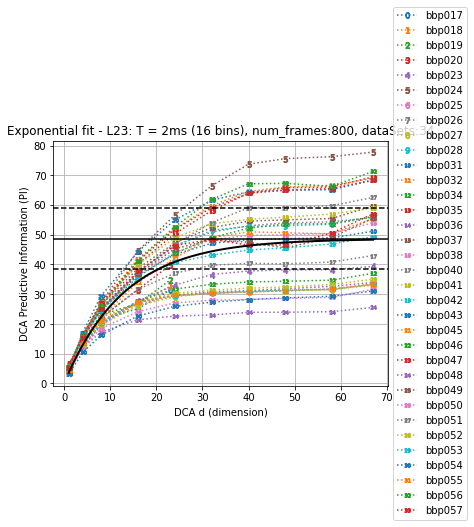

{'MSE': 106.09906640732201, 'params': [48.63360175443906, 0.07643622952811184], 'threshold': 48.63360175443906}


<Figure size 432x324 with 0 Axes>

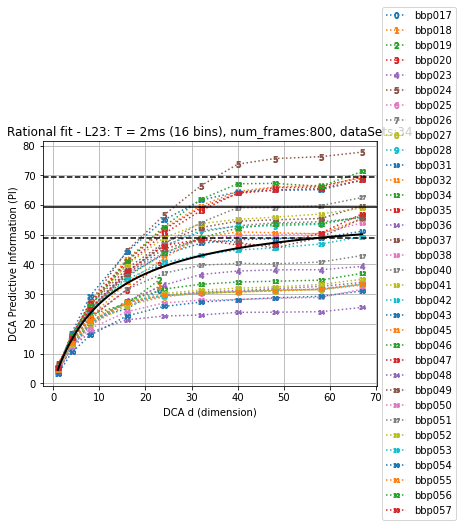

{'MSE': 105.57016615463047, 'params': [26.59385059746782, 8.611577193237165e-07, 0.44871672084335235, 5.4479593433261195], 'threshold': 59.26645779431913}


<Figure size 432x324 with 0 Axes>

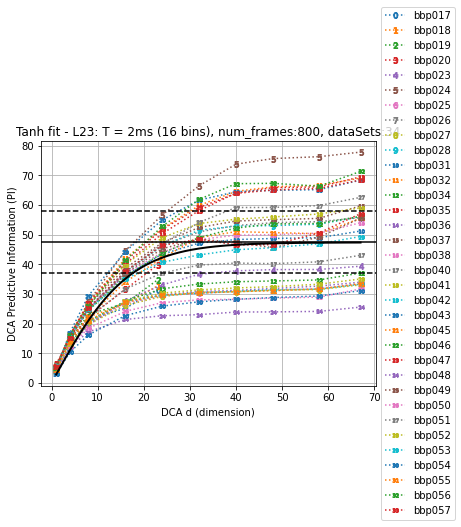

{'MSE': 108.89944057657397, 'params': [47.3613305481164, 0.0595509450640624], 'threshold': 47.3613305481164}


In [228]:
%matplotlib inline

L23 = SORTED_CELL_TYPES['L23'] # ['bbp020', 'bbp024', 'bbp031', 'bbp041', 'bbp050', 'bbp057']

print(curve_fit_DCA_vs_PI(L23, cell_type = 'L23', fit='exp', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(L23, cell_type = 'L23', fit='rat', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(L23, cell_type = 'L23', fit='tanh', normalizer='unnorm'))

<Figure size 432x324 with 0 Axes>

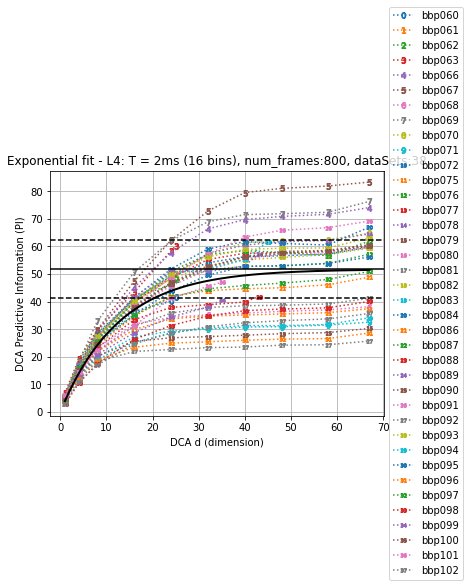

{'MSE': 110.15612857336392, 'params': [51.73276184513625, 0.07840550462702398], 'threshold': 51.73276184513625}


<Figure size 432x324 with 0 Axes>

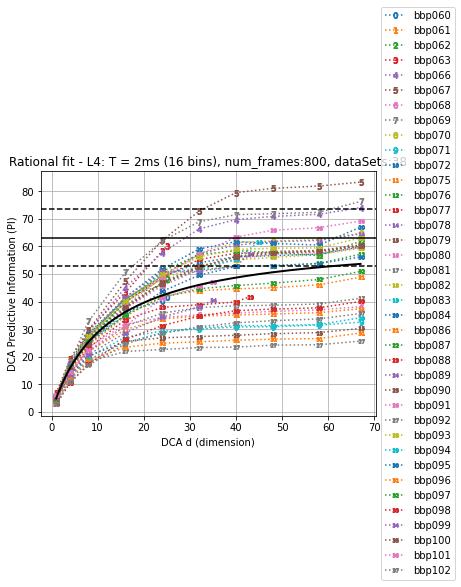

{'MSE': 110.29202200377381, 'params': [24.544971931401086, 1.1677484809266595e-12, 0.38828156623006005, 4.634104645506767], 'threshold': 63.214363148154156}


<Figure size 432x324 with 0 Axes>

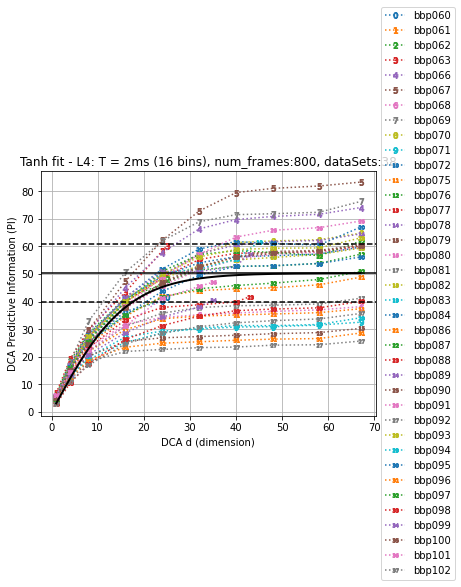

{'MSE': 112.72337423978603, 'params': [50.31684649765337, 0.06129276841278935], 'threshold': 50.31684649765337}


In [229]:
%matplotlib inline

L4 = SORTED_CELL_TYPES['L4'] # ['bbp061', 'bbp063', 'bbp070', 'bbp079', 'bbp088', 'bbp101']

print(curve_fit_DCA_vs_PI(L4, cell_type = 'L4', fit='exp', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(L4, cell_type = 'L4', fit='rat', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(L4, cell_type = 'L4', fit='tanh', normalizer='unnorm'))

<Figure size 432x324 with 0 Axes>

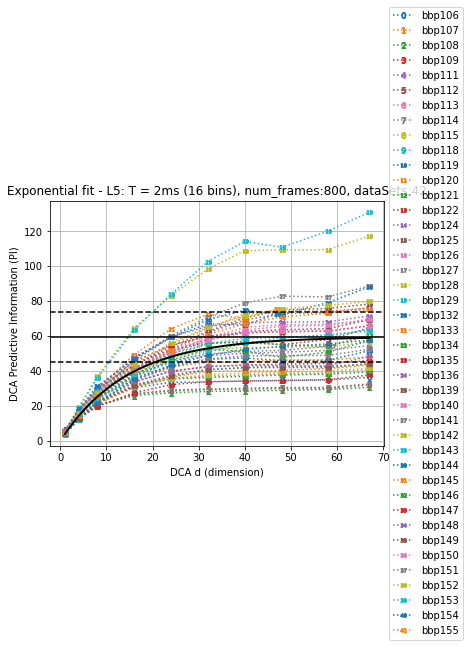

{'MSE': 199.98970595224748, 'params': [59.518267825210295, 0.06880146643089077], 'threshold': 59.518267825210295}


<Figure size 432x324 with 0 Axes>

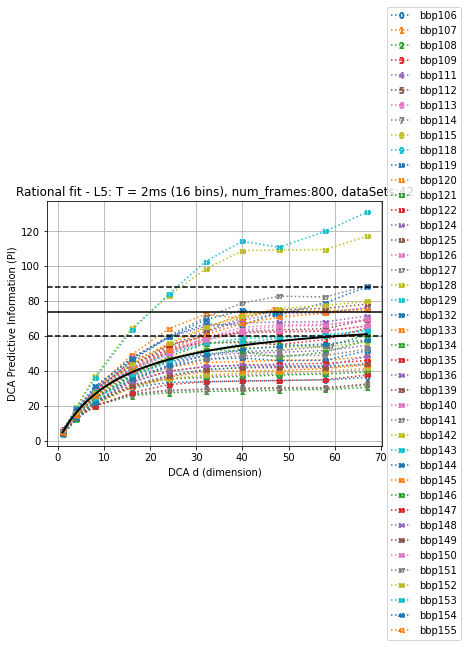

{'MSE': 200.63266241836797, 'params': [42.06977072385899, 7.893670401977774e-10, 0.5688009340154323, 8.055687661476865], 'threshold': 73.96220401198845}


<Figure size 432x324 with 0 Axes>

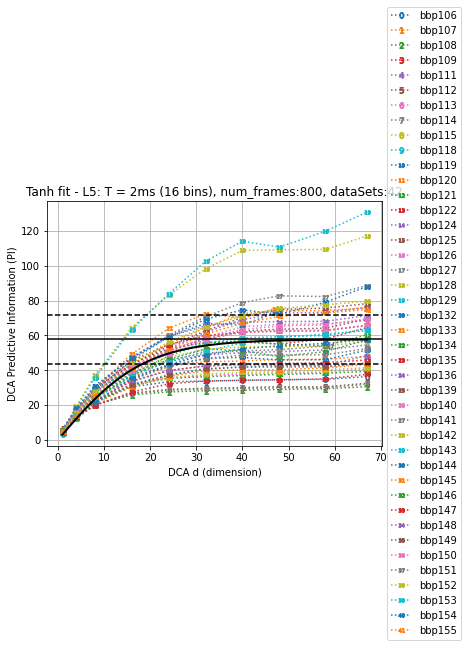

{'MSE': 202.58957142774062, 'params': [57.74725409929408, 0.05386605515098972], 'threshold': 57.74725409929408}


In [230]:
%matplotlib inline

L5 = SORTED_CELL_TYPES['L5'] # ['bbp107', 'bbp115', 'bbp129', 'bbp140', 'bbp148', 'bbp154']

print(curve_fit_DCA_vs_PI(L5, cell_type = 'L5', fit='exp', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(L5, cell_type = 'L5', fit='rat', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(L5, cell_type = 'L5', fit='tanh', normalizer='unnorm'))

<Figure size 432x324 with 0 Axes>

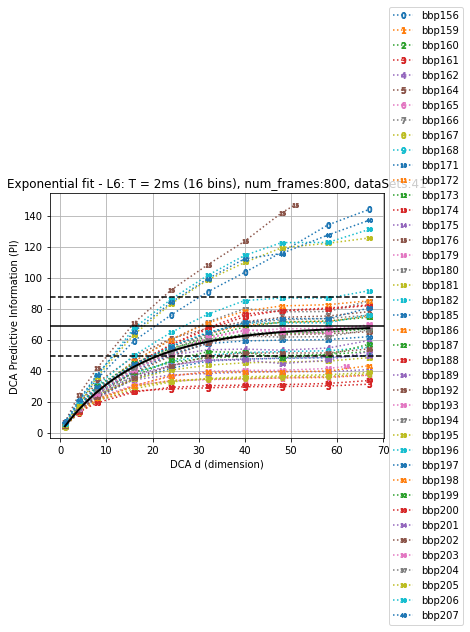

{'MSE': 360.7448807167566, 'params': [68.66074258427275, 0.060337910313518886], 'threshold': 68.66074258427275}


<Figure size 432x324 with 0 Axes>

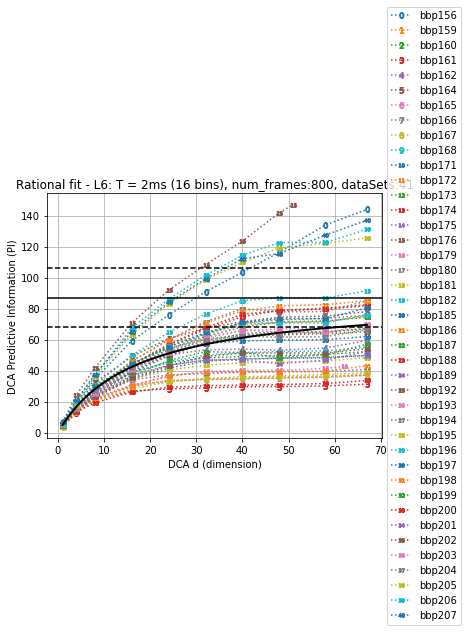

{'MSE': 361.83062770244305, 'params': [31.58616475356869, 1.4398270607966731e-21, 0.36257448896278555, 6.126634827051198], 'threshold': 87.11634633734718}


<Figure size 432x324 with 0 Axes>

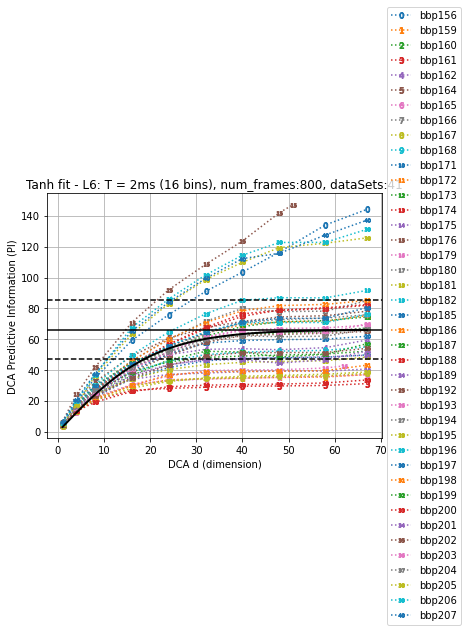

{'MSE': 363.690631126782, 'params': [66.26070213678332, 0.047541114934624984], 'threshold': 66.26070213678332}


In [231]:
%matplotlib inline

L6 = SORTED_CELL_TYPES['L6'] # ['bbp159', 'bbp171', 'bbp185', 'bbp194', 'bbp201', 'bbp203']

print(curve_fit_DCA_vs_PI(L6, cell_type = 'L6', fit='exp', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(L6, cell_type = 'L6', fit='rat', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(L6, cell_type = 'L6', fit='tanh', normalizer='unnorm'))

### 1.2.2 Curve-fitted Data to Individual Neurons
Below are the DCA vs PI graphs with curves fitted to single neurons, to see if rational fit is better or worse than log fit. 

<Figure size 432x324 with 0 Axes>

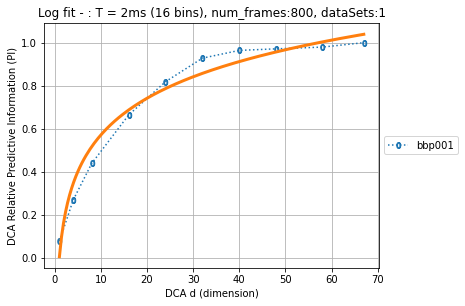

{'MSE': 0.002863736890091024, 'params': [0.2456478137746185, 0.006018261485843063]}


<Figure size 432x324 with 0 Axes>

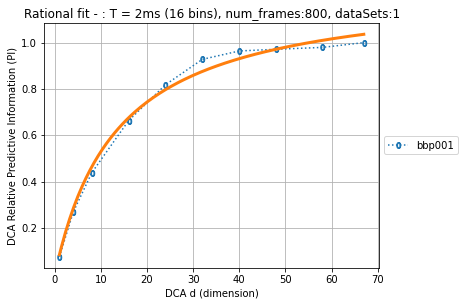

{'MSE': 0.0007568092048269948, 'params': [5.397260013376545, 5.761640065140997e-22, 4.340492073566963, 58.27084778273326], 'threshold': 1.243467312437952}


<Figure size 432x324 with 0 Axes>

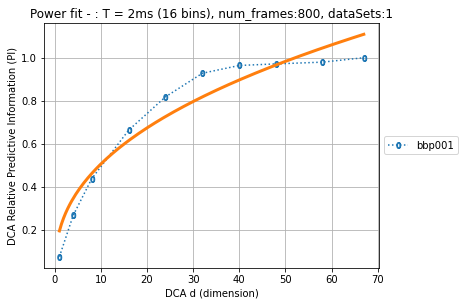

{'MSE': 0.006428960182269549, 'params': [0.19715152158562277, 0.41069610082551317]}


<Figure size 432x324 with 0 Axes>

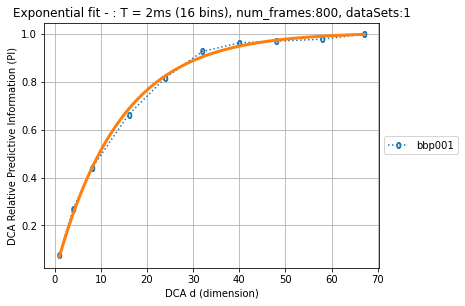

{'MSE': 0.00018975517215668304, 'params': [1.0081192045831877, 0.07146128349726855], 'threshold': 1.0081192045831877}


<Figure size 432x324 with 0 Axes>

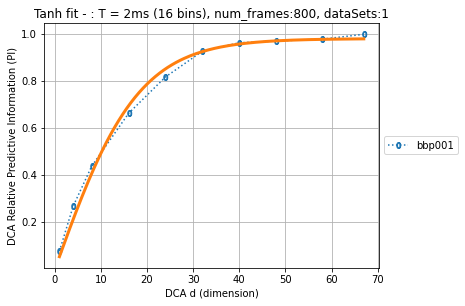

{'MSE': 0.0007270783630130024, 'params': [0.9817656204358229, 0.05533238376203556], 'threshold': 0.9817656204358229}


<Figure size 432x324 with 0 Axes>

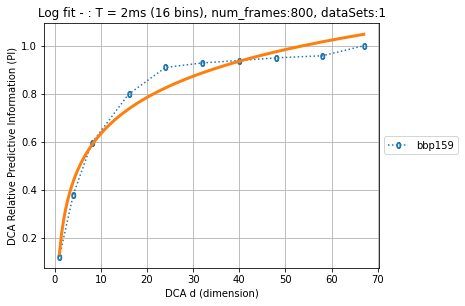

{'MSE': 0.0022306849233153605, 'params': [0.2168946059912494, 0.13579746737016266]}


<Figure size 432x324 with 0 Axes>

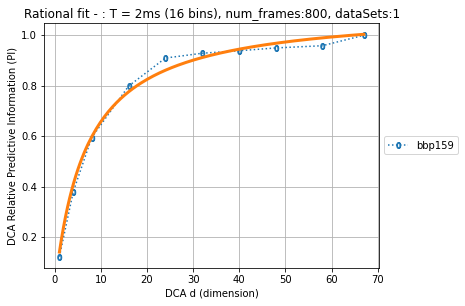

{'MSE': 0.0005669263467168548, 'params': [4.596234751764361, 4.741448092177657e-22, 4.157197655762887, 28.244324151651533], 'threshold': 1.1056089058918963}


<Figure size 432x324 with 0 Axes>

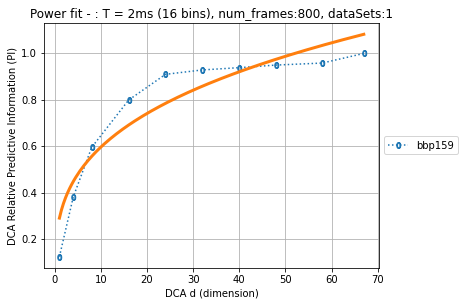

{'MSE': 0.007937416377321673, 'params': [0.28985465333513377, 0.3133964055499596]}


<Figure size 432x324 with 0 Axes>

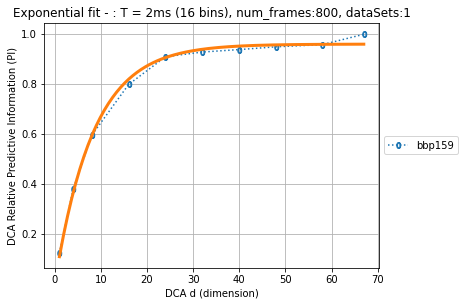

{'MSE': 0.0002845797131537143, 'params': [0.9606956506772442, 0.11993659298281238], 'threshold': 0.9606956506772442}


<Figure size 432x324 with 0 Axes>

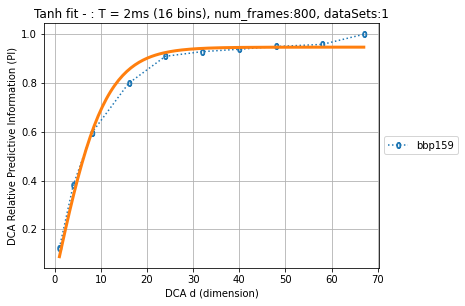

{'MSE': 0.000980908687775031, 'params': [0.9472647391886744, 0.09259818454597535], 'threshold': 0.9472647391886744}


In [195]:
%matplotlib inline

print(curve_fit_DCA_vs_PI(['bbp001'], fit='log'))
print(curve_fit_DCA_vs_PI(['bbp001'], fit='rat'))
print(curve_fit_DCA_vs_PI(['bbp001'], fit='pow'))
print(curve_fit_DCA_vs_PI(['bbp001'], fit='exp'))
print(curve_fit_DCA_vs_PI(['bbp001'], fit='tanh'))

print(curve_fit_DCA_vs_PI(['bbp159'], fit='log'))
print(curve_fit_DCA_vs_PI(['bbp159'], fit='rat'))
print(curve_fit_DCA_vs_PI(['bbp159'], fit='pow'))
print(curve_fit_DCA_vs_PI(['bbp159'], fit='exp'))
print(curve_fit_DCA_vs_PI(['bbp159'], fit='tanh'))

<Figure size 432x324 with 0 Axes>

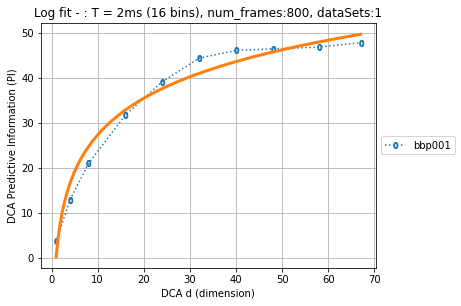

{'MSE': 6.5459186147963875, 'params': [11.7444223151772, 0.2877323381798157]}


<Figure size 432x324 with 0 Axes>

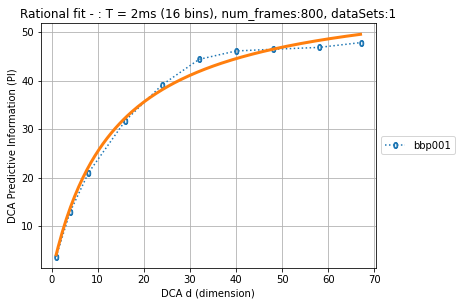

{'MSE': 1.729911528837637, 'params': [34.03675205791694, 8.4951930873565e-30, 0.572525712238623, 7.686123525982453]}


<Figure size 432x324 with 0 Axes>

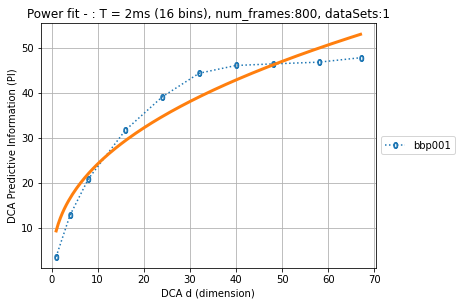

{'MSE': 14.695292111051746, 'params': [9.42582927837377, 0.41069566221549425]}


<Figure size 432x324 with 0 Axes>

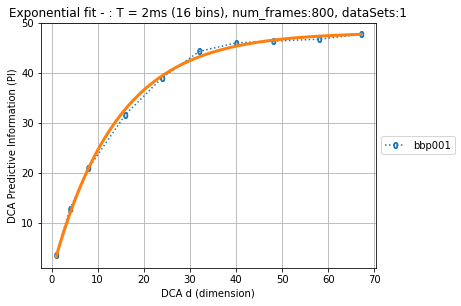

{'MSE': 0.4337416324705761, 'params': [48.19817916933976, 0.07146128350701443]}


<Figure size 432x324 with 0 Axes>

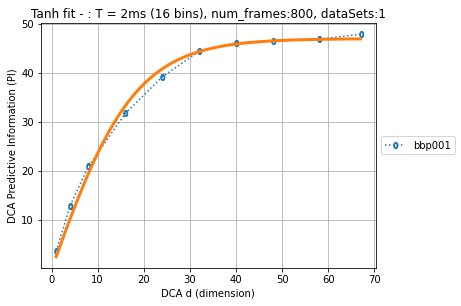

{'MSE': 1.6619528866434525, 'params': [46.938221520645094, 0.05533233767469083]}


<Figure size 432x324 with 0 Axes>

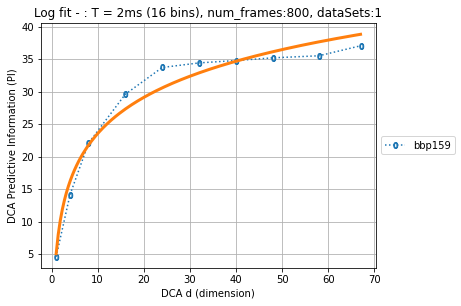

{'MSE': 3.069095784616691, 'params': [8.045163207129756, 5.037067444419369]}


<Figure size 432x324 with 0 Axes>

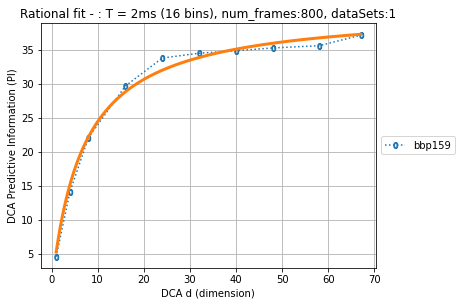

{'MSE': 0.7800076302622083, 'params': [19.57449763321199, 1.899644890624528e-15, 0.477312700216574, 3.242899658043608]}


<Figure size 432x324 with 0 Axes>

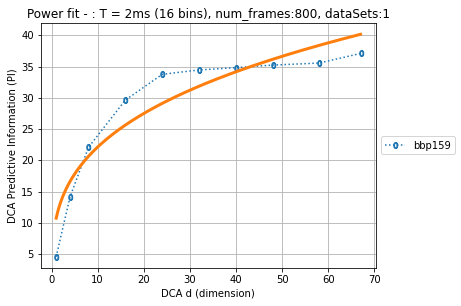

{'MSE': 10.920722548071573, 'params': [10.751473039926127, 0.3133953708193616]}


<Figure size 432x324 with 0 Axes>

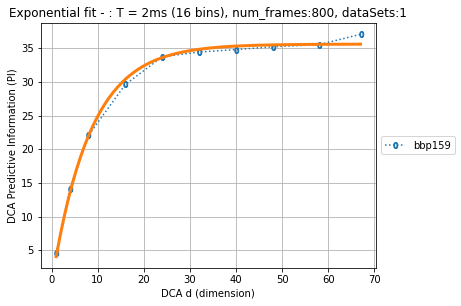

{'MSE': 0.3915400103890418, 'params': [35.63460587458585, 0.1199365274046856]}


<Figure size 432x324 with 0 Axes>

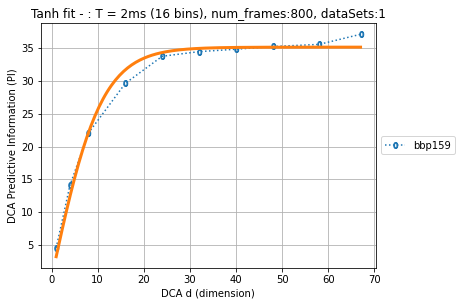

{'MSE': 1.3495867067547205, 'params': [35.13643282728129, 0.09259781166849901]}


In [172]:
%matplotlib inline

print(curve_fit_DCA_vs_PI(['bbp001'], fit='log', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(['bbp001'], fit='rat', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(['bbp001'], fit='pow', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(['bbp001'], fit='exp', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(['bbp001'], fit='tanh', normalizer='unnorm'))

print(curve_fit_DCA_vs_PI(['bbp159'], fit='log', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(['bbp159'], fit='rat', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(['bbp159'], fit='pow', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(['bbp159'], fit='exp', normalizer='unnorm'))
print(curve_fit_DCA_vs_PI(['bbp159'], fit='tanh', normalizer='unnorm'))

## 1.3 Normalized Mutual Information
To offer a more robust comparison between cells, we compute the normalized mutual information. Given two random variables $X$ and $Y$, there is no agreed upon notion in literature for how such a quantity should be measured. However, all of them take the form 
$$I_{norm}(X;Y) = \frac{I(X;Y)}{f(X,Y)},$$
where $f$ is some function. The following paper (https://arxiv.org/abs/1110.2515) suggests that since
\begin{align*}
I(X;Y) &\le \min(H(X), H(Y)) \\
&\le \sqrt{H(X)H(Y)} \\
&\le \frac12(H(X)+H(Y))\\
&\le \max(H(X),H(Y)) \\
\end{align*}
$f$ can take on any of the expressions on the right hand side. The paper uses the so-called normalized information distance, which uses the choice $f(X,Y) = \max(H(X), H(Y))$. We will see that in our case, the choice of $f$ is irrelevant. 

Following the notation in DCA PAPER, let $X=\{x_t\}$ with $x_t\in\mathbb{R}^n$ be a discrete time series with stationary probability distribution $P(X)$. The predictive information is calculated to be $$I_T^{pred}(X) = 2H_X(T) - H_X(2T).$$
However, the all four options for $f$ agree with each other since $H(X_{past}) = H(X_{future}) = H_X(T)$ by the stationarity assumption. Thus, the normalized predictive information is
\begin{align*}
I_T^{norm}(X) &= \frac{I_T^{pred}(X)}{H_X(T)} = 2 - \frac{H_X(2T)}{H_X(T)}.
\end{align*}


# 2. DCA Dimension vs Predictive Information Graphs (300-700 Frame Average)

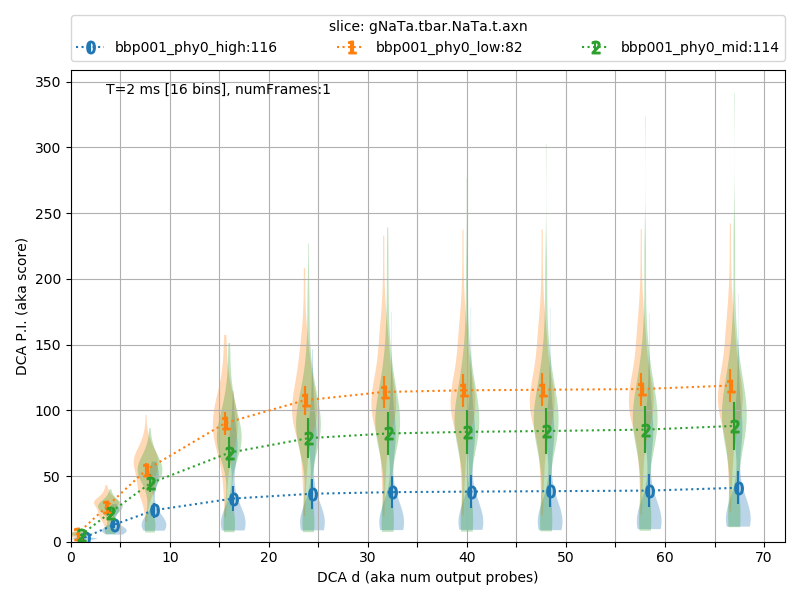

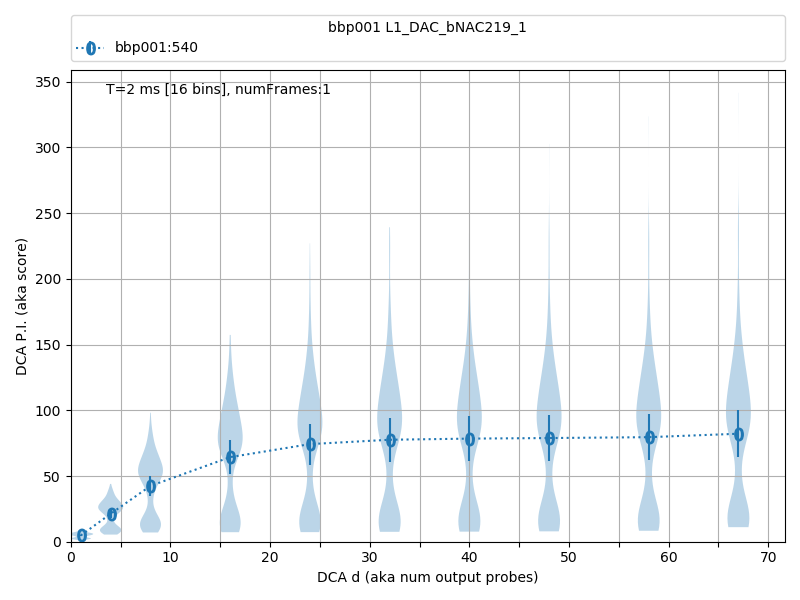

In [16]:
def view_cell_DCA_vs_PI(cell_name):
    directory_path = DCA_300_TO_700FRAME_DATA_CSV_DIR + cell_name
    image_files = [file for file in os.listdir(directory_path) if file.endswith('.png')]
    for file in image_files:
        display(Image(directory_path + "/" + file))
    
view_cell_DCA_vs_PI("bbp001")

In [17]:
def read_cell_yaml(cell):
    yaml_filename = DCA_300_TO_700FRAME_DATA_CSV_DIR + cell + "/pi1frame_" + cell + ".yaml"
    file = open(yaml_filename, 'r')
    data = yaml.load(file, Loader=yaml.CLoader)
    file.close()
    return data

def graph_DCA_vs_PI_framewise(cell, img_width=6, img_height=4.5):
    dca_to_pi_perframe = read_cell_yaml(cell)['score'][cell]
    # mean PI per DCA d, set of all given DCA d values, and std of
    # PI per DCA d provided
    mean_pi = []
    avail_dims = []
    std_pi = []
    for dim in dca_to_pi_perframe.keys():
        mean_pi.append(np.mean(dca_to_pi_perframe[dim]))
        avail_dims.append(dim)
        std_pi.append(0.5 * np.std(dca_to_pi_perframe[dim]))
        
    plt.figure(figsize=(img_width, img_height))
    plt.violinplot(list(dca_to_pi_perframe.values()), positions=avail_dims, widths=2, showextrema=False)
    plt.plot(avail_dims, mean_pi, linestyle='dotted', marker='$0$', markersize=10, label=cell, color='b')
    plt.errorbar(avail_dims, mean_pi, yerr=std_pi, fmt='', linestyle='dotted',color='b')
    plt.title('T = 2ms ({} bins), num_frames:{}'.format(16, 1))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

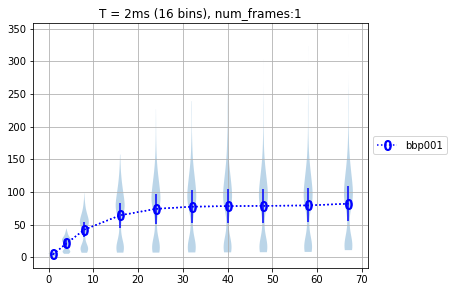

In [18]:
graph_DCA_vs_PI_framewise('bbp001')